# Sanity Check: Check confusion matrices of the best performing models

After training without any form of balancing or weighing, the best performing modes were RandomForest, LinearSVC, SVC, and the RidgeClassifier.

Let's look at them closely, particularly at their confusion matrix for each label and do a sanity check of their current performance for the labels

In [32]:
import os

import spacy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier

from preprocessing.InputDataset import FramingArticleDataset
from preprocessing.BOWPipeline import basic_tokenizing_and_cleaning, BOWPipeline
from training.MultiLabelEstimator import MultiLabelEstimator
from benchmark_subtask_2 import LABELS


In [8]:

data_dir = os.path.join('..', '..' ,'..', 'data')

mlb = MultiLabelBinarizer()
mlb.fit([LABELS])

train_data = FramingArticleDataset(
        data_dir=data_dir,
        language='en',
        subtask=2,
        split='train',
        load_preprocessed_units_of_analysis=True,
        units_of_analysis_dir=os.path.join(data_dir, 'preprocessed')
)

X, y = train_data.df.raw_text, train_data.df.frames
X = X.to_numpy()
y = mlb.transform(y.str.lower().str.split(','))

433it [00:00, 30130.79it/s]


In [9]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [10]:
# Define vectorizing pipeline
nlp = spacy.load('en_core_web_sm')

vectorizing_pipeline = BOWPipeline(
        tokenizer=lambda string: basic_tokenizing_and_cleaning(string, spacy_nlp_model=nlp),
        use_tfidf=True,
        min_df=0.05,
        max_df=0.95,
        max_features=10000,
        ngram_range=(1, 1),
        min_var=0.001,
        corr_threshold=0.9
    )

In [11]:
X_train = vectorizing_pipeline.pipeline.fit_transform(X_train)
X_test = vectorizing_pipeline.pipeline.transform(X_test)

In [52]:

# Initiliaze, fit model and get confusion matrices
models = (LinearSVC(), SVC(), RandomForestClassifier(), RidgeClassifier())
cm_dict = {}
for model in models:
    print(model.__class__.__name__)
    print(len(model.__class__.__name__)*'-')
    multilabel_cls = MultiLabelEstimator(
                base_estimator=model,
                base_estimator_hyperparam_dist=dict(),
                treat_labels_as_independent=True,
                scoring_functions=('f1_micro',)
            )

    # Fit model
    multilabel_cls.multi_label_estimator.fit(X_train, y_train)

    # Get predictions on test
    y_test_pred = multilabel_cls.multi_label_estimator.predict(X_test)

    # Store confusion matrices
    confusion_matrices = multilabel_confusion_matrix(y_true=y_test, y_pred=y_test_pred)
    cm_dict[model.__class__.__name__] = confusion_matrices
    for idx, label in enumerate(mlb.classes_):
        print(label)
        print(confusion_matrices[idx, :, :])
        print('\n')
    print('\n\n')

LinearSVC
---------
capacity_and_resources
[[134   0]
 [  8   1]]


crime_and_punishment
[[52 17]
 [14 60]]


cultural_identity
[[132   2]
 [  7   2]]


economic
[[135   1]
 [  6   1]]


external_regulation_and_reputation
[[96  9]
 [13 25]]


fairness_and_equality
[[99  4]
 [32  8]]


health_and_safety
[[117   1]
 [ 14  11]]


legality_constitutionality_and_jurisprudence
[[54 18]
 [31 40]]


morality
[[57 15]
 [28 43]]


policy_prescription_and_evaluation
[[124   6]
 [ 13   0]]


political
[[58 12]
 [ 9 64]]


public_opinion
[[137   0]
 [  6   0]]


quality_of_life
[[109   2]
 [ 23   9]]


security_and_defense
[[63 26]
 [15 39]]





SVC
---
capacity_and_resources
[[134   0]
 [  9   0]]


crime_and_punishment
[[54 15]
 [16 58]]


cultural_identity
[[134   0]
 [  9   0]]


economic
[[136   0]
 [  7   0]]


external_regulation_and_reputation
[[99  6]
 [14 24]]


fairness_and_equality
[[101   2]
 [ 35   5]]


health_and_safety
[[118   0]
 [ 17   8]]


legality_constitutionality_and_jurisp

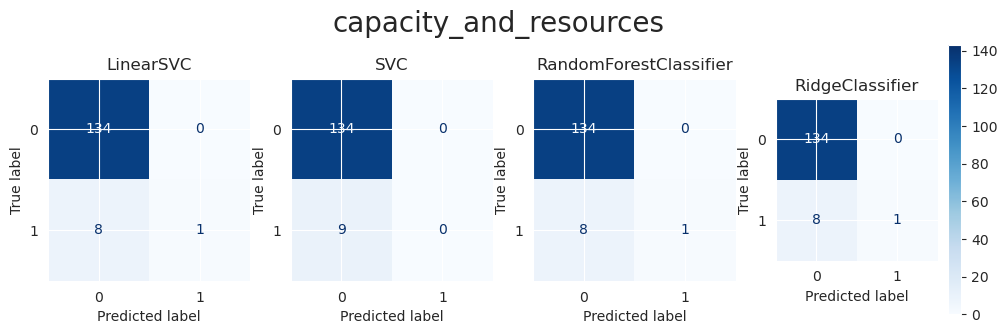

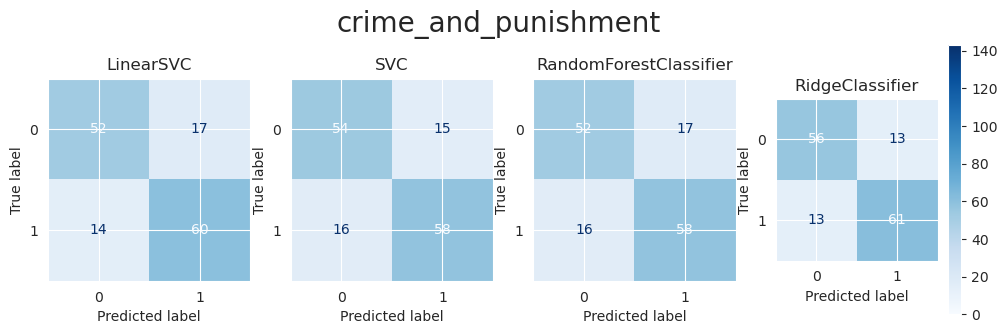

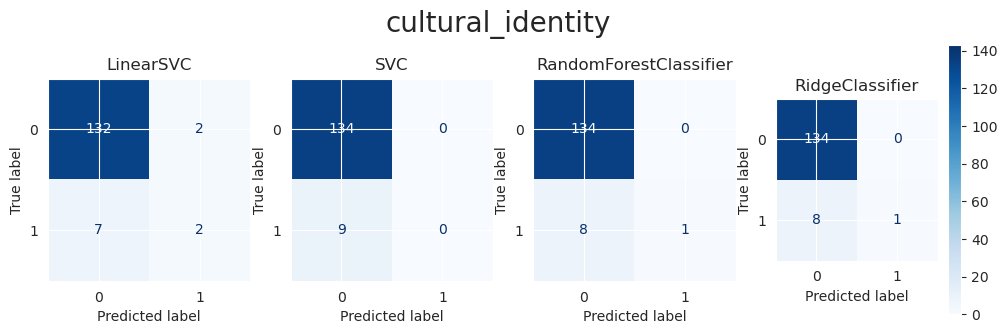

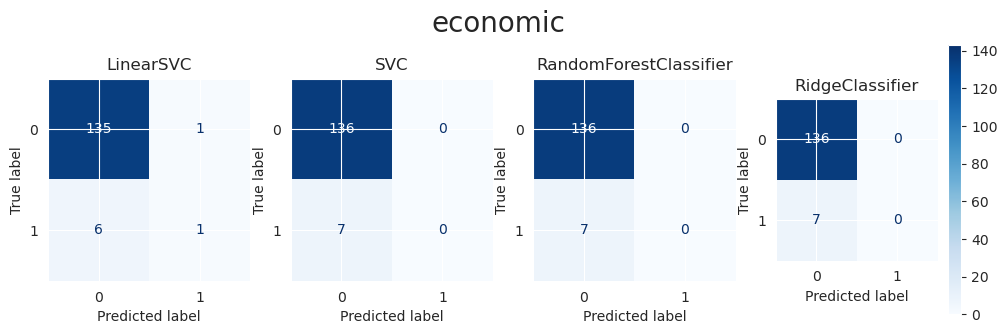

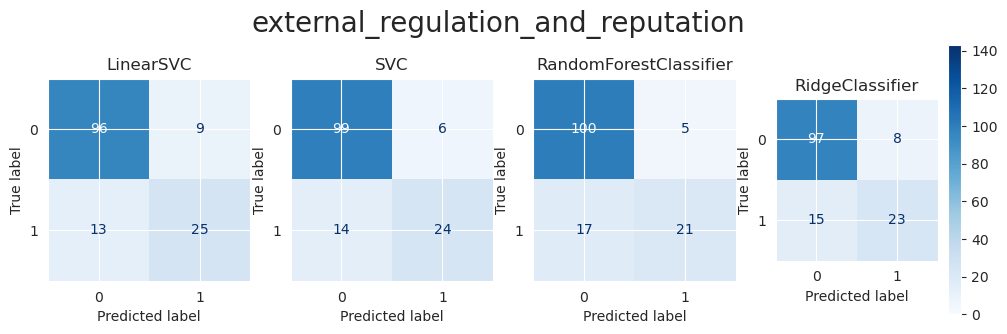

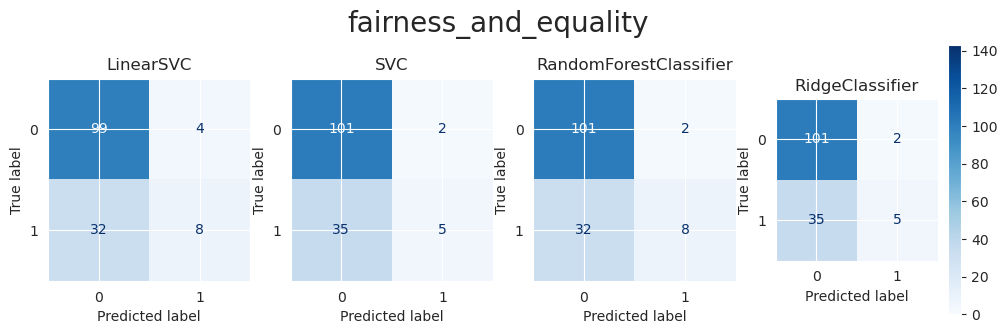

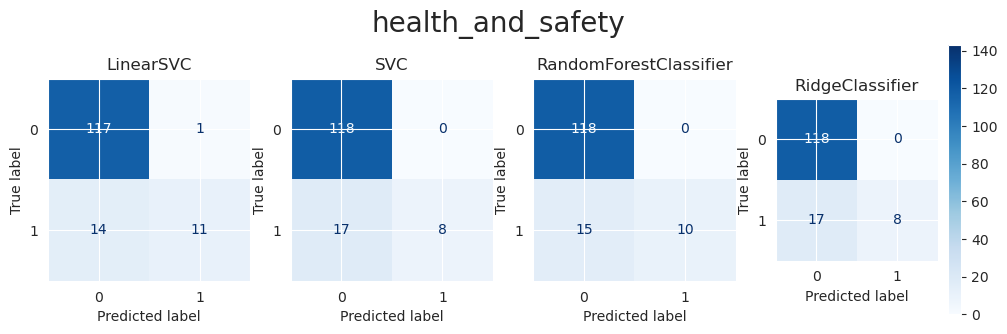

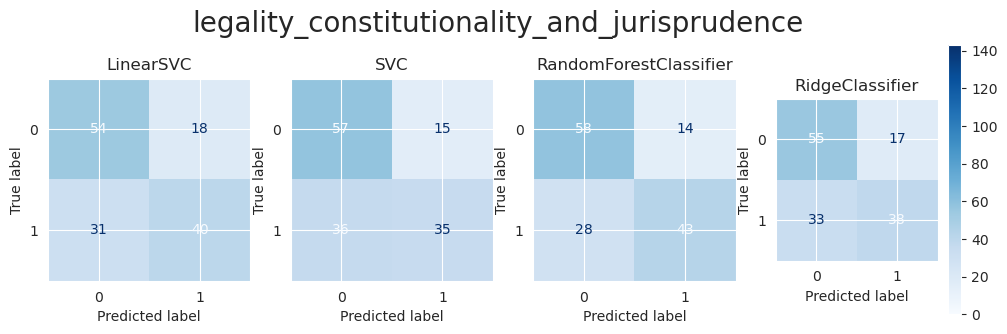

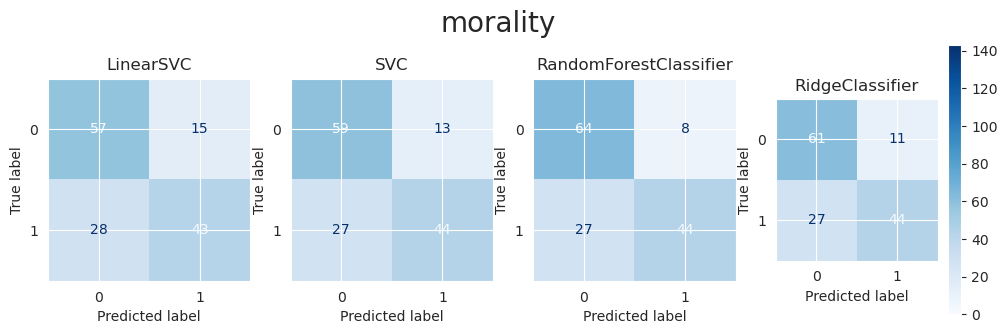

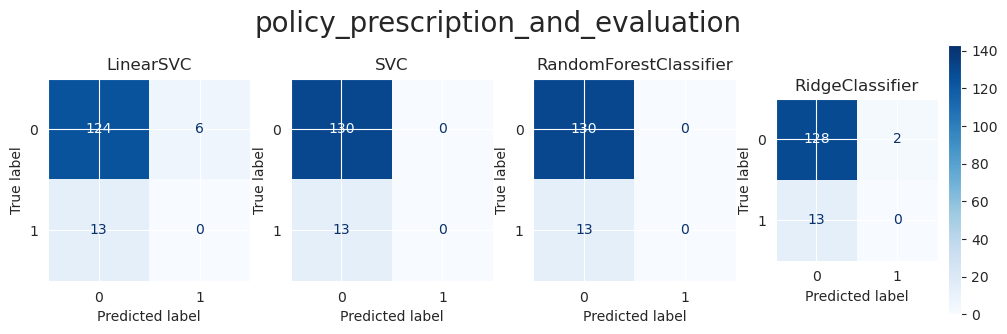

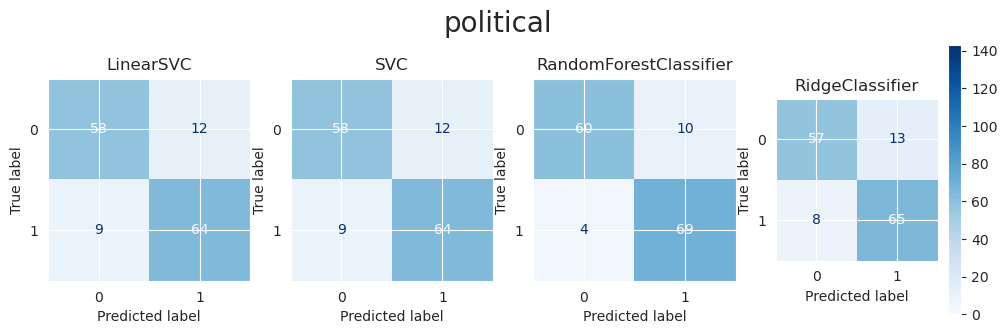

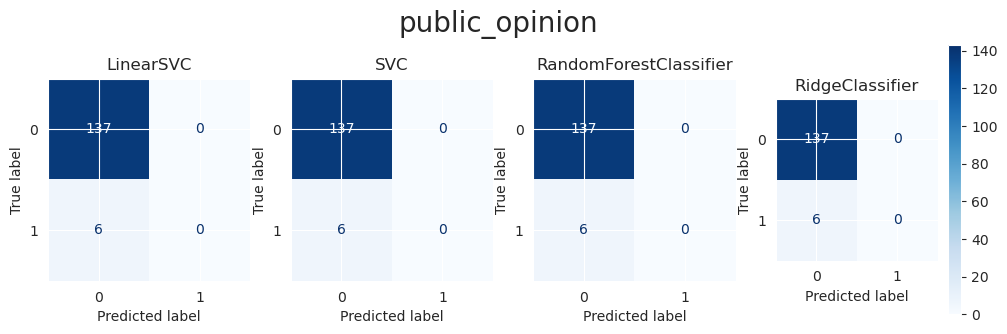

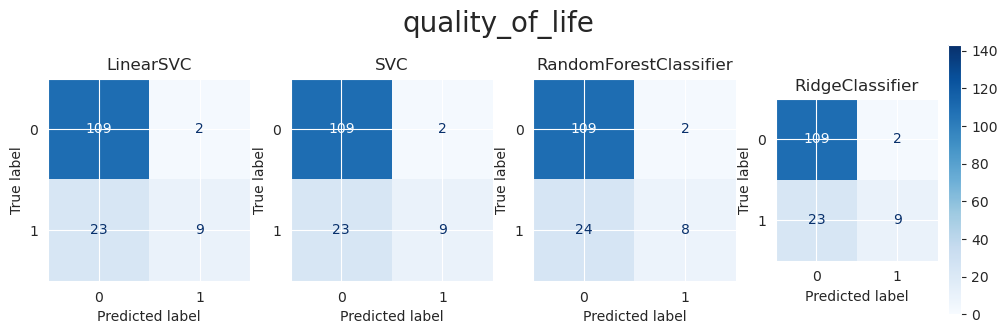

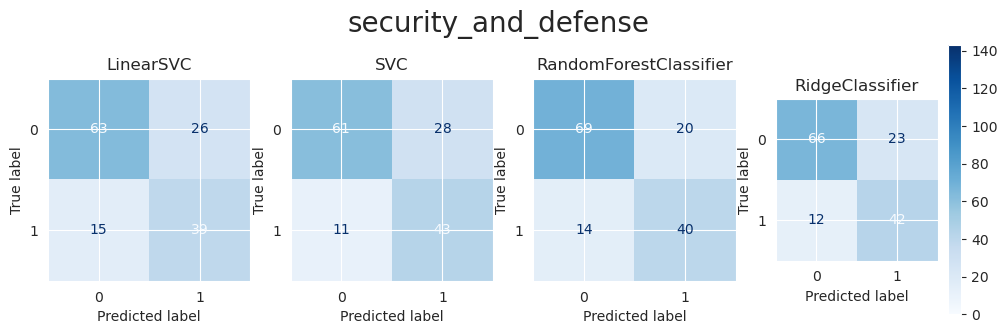

In [85]:
# Plot multilabel confusion matrices side by side for all models
for idx, label in enumerate(mlb.classes_):
    fig, axes = plt.subplots(1, len(models), figsize=(12,3.5))
    fig.suptitle(label, fontsize=20)

    for i, (model, ax_) in enumerate(zip(models, axes)):
        model_name = model.__class__.__name__
        cm_plot = ConfusionMatrixDisplay(cm_dict[model_name][idx, :, :])
        if i == len(models) - 1:
            cm_plot.plot(cmap='Blues', ax=ax_, colorbar=True, im_kw={'vmin':0, 'vmax':y_test.shape[0]})
        else:
            cm_plot.plot(cmap='Blues', ax=ax_, colorbar=False, im_kw={'vmin':0, 'vmax':y_test.shape[0]})
        ax_.set_title(model_name)

    plt.show()

    print('\n\n')

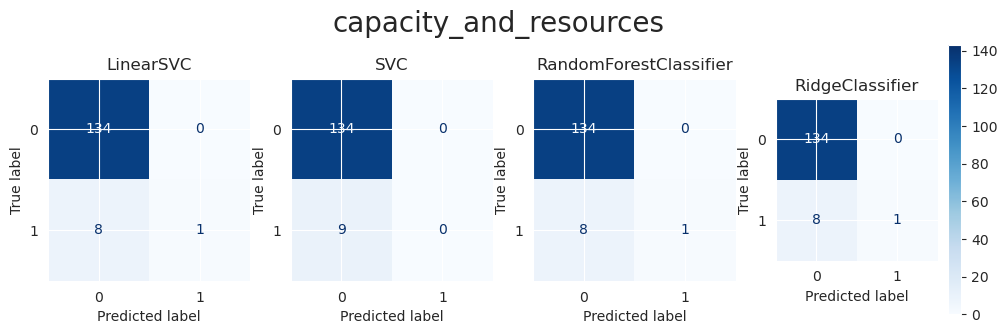

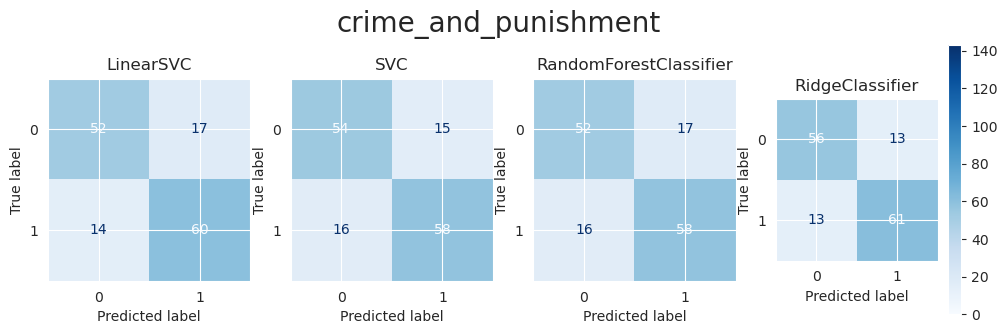

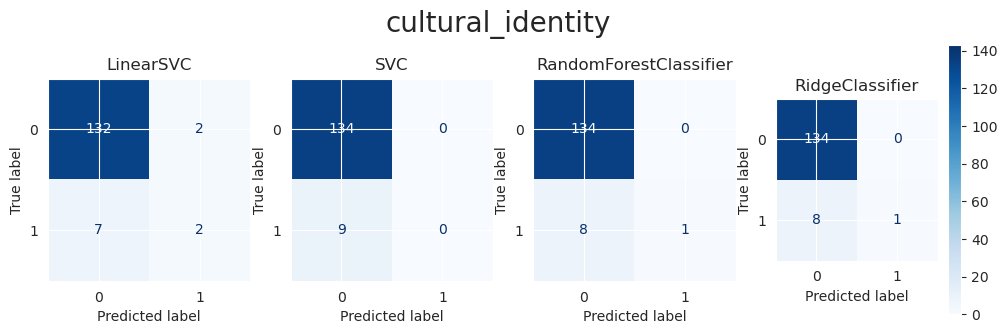

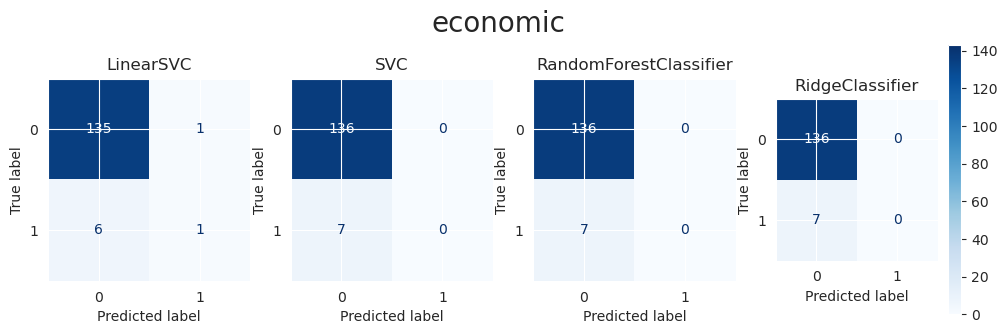

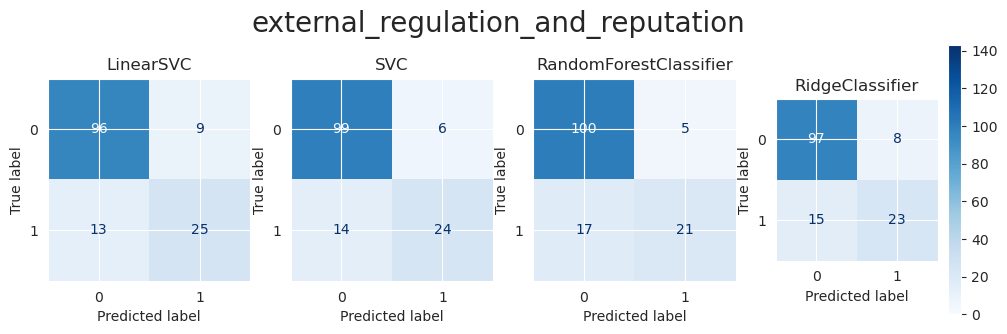

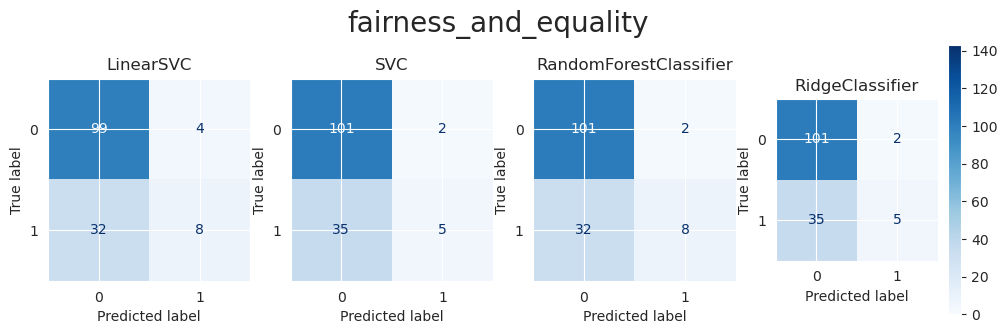

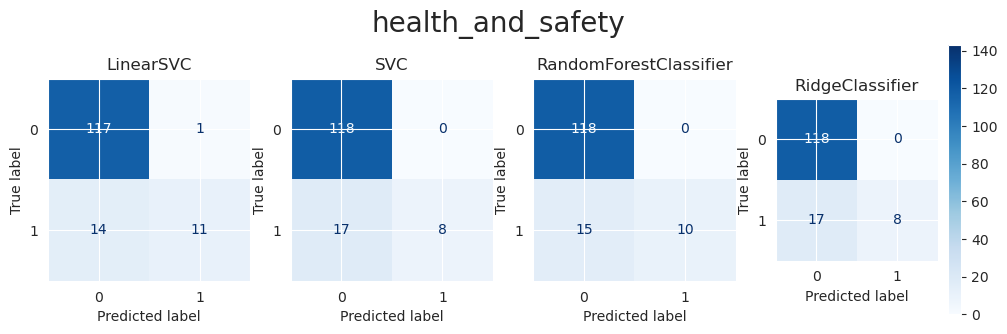

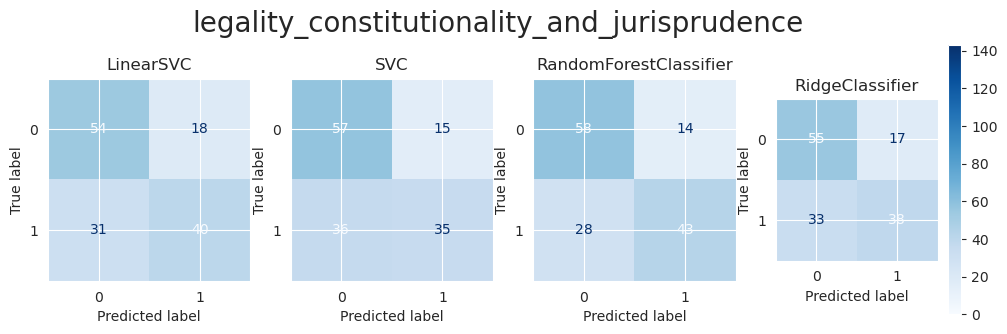

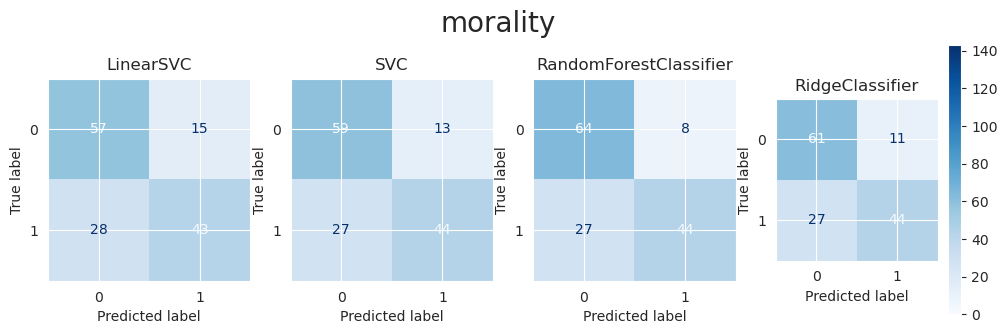

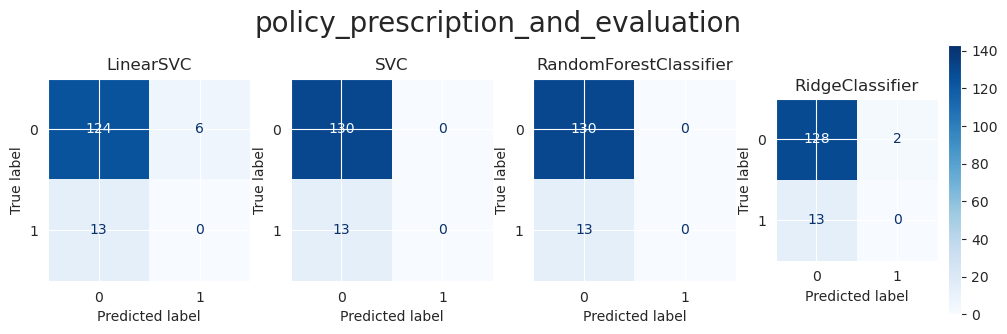

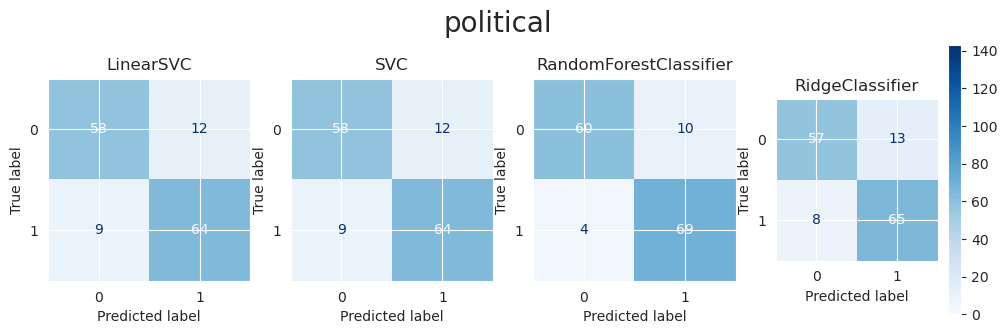

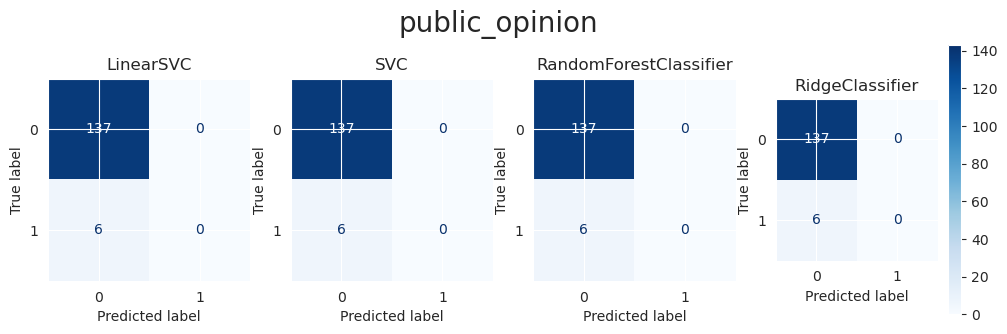

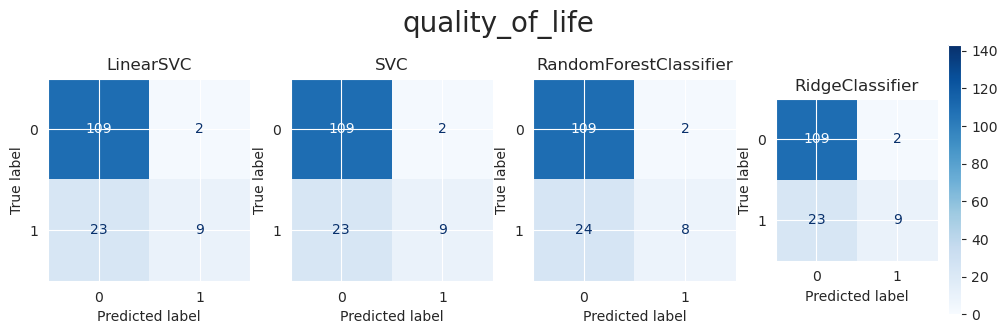

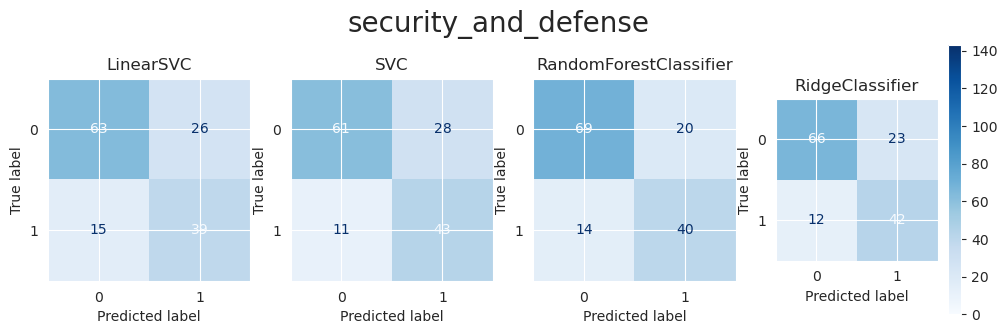

In [85]:
#### TODO: NORMALIZED Confusion matrices
# Plot multilabel confusion matrices side by side for all models
for idx, label in enumerate(mlb.classes_):
    fig, axes = plt.subplots(1, len(models), figsize=(12,3.5))
    fig.suptitle(label, fontsize=20)

    for i, (model, ax_) in enumerate(zip(models, axes)):
        model_name = model.__class__.__name__
        cm_plot = ConfusionMatrixDisplay(cm_dict[model_name][idx, :, :])
        if i == len(models) - 1:
            cm_plot.plot(cmap='Blues', ax=ax_, colorbar=True, im_kw={'vmin':0, 'vmax':y_test.shape[0]})
        else:
            cm_plot.plot(cmap='Blues', ax=ax_, colorbar=False, im_kw={'vmin':0, 'vmax':y_test.shape[0]})
        ax_.set_title(model_name)

    plt.show()

    print('\n\n')

In [47]:
for ax_ in axes:
    print(type(ax_))

<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>


LinearSVC
---------
capacity_and_resources


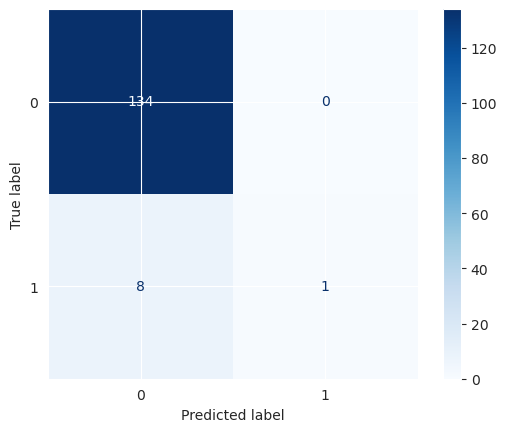



crime_and_punishment


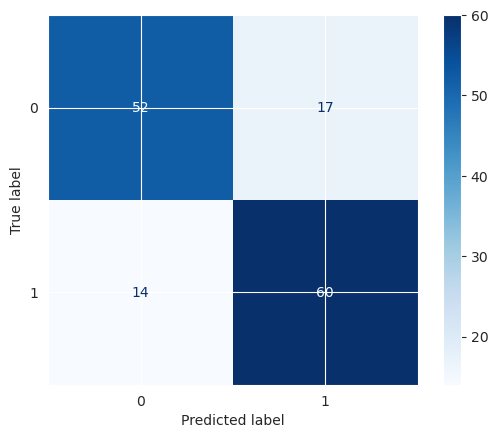



cultural_identity


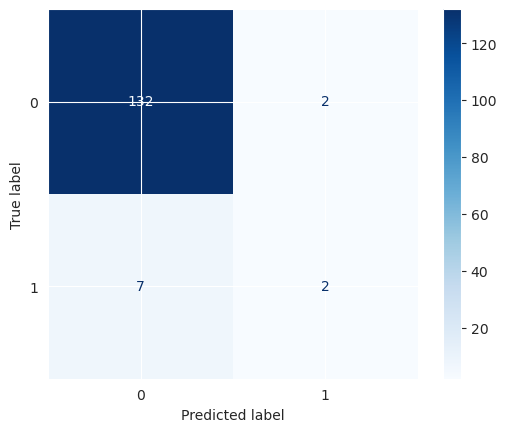



economic


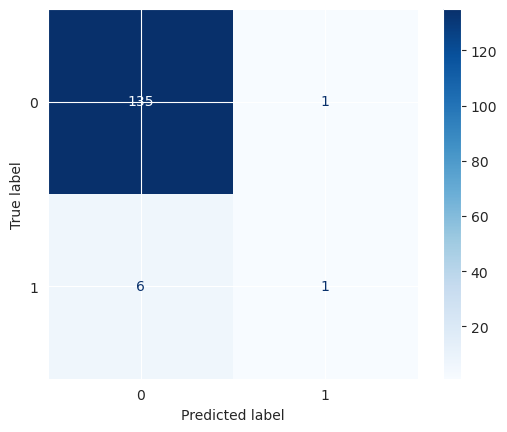



external_regulation_and_reputation


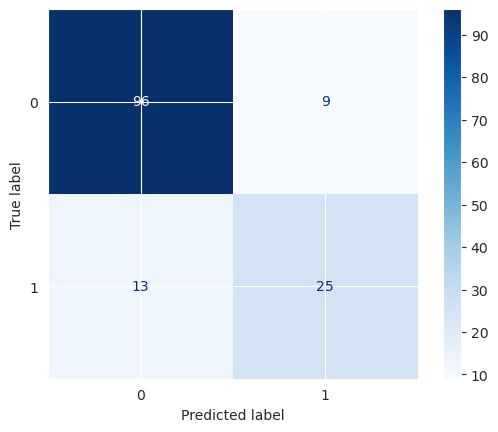



fairness_and_equality


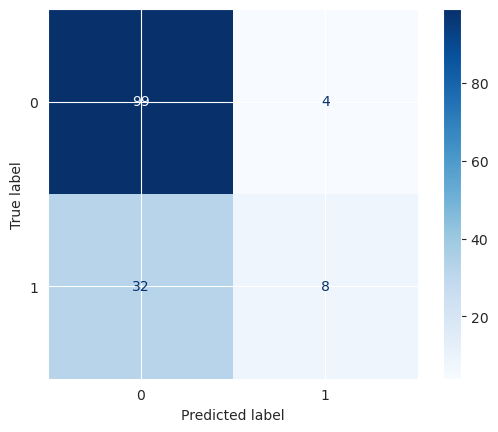



health_and_safety


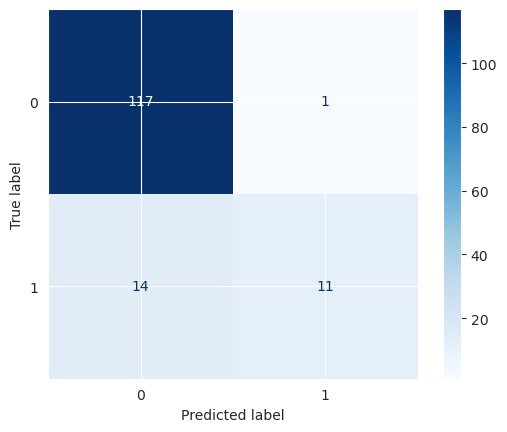



legality_constitutionality_and_jurisprudence


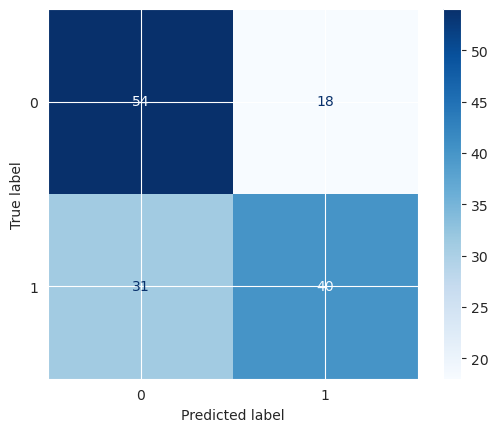



morality


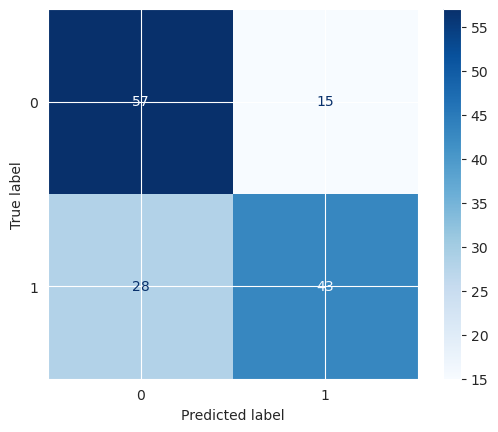



policy_prescription_and_evaluation


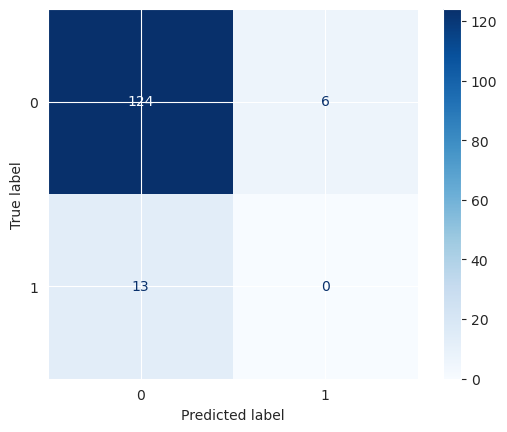



political


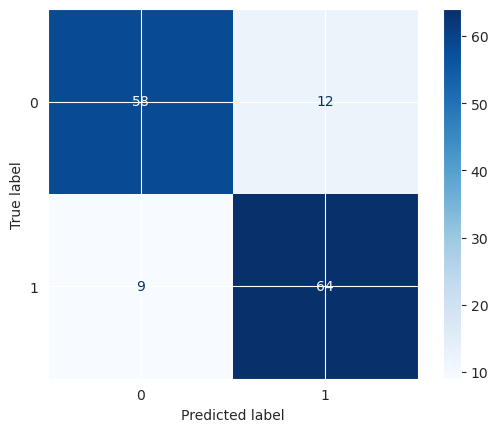



public_opinion


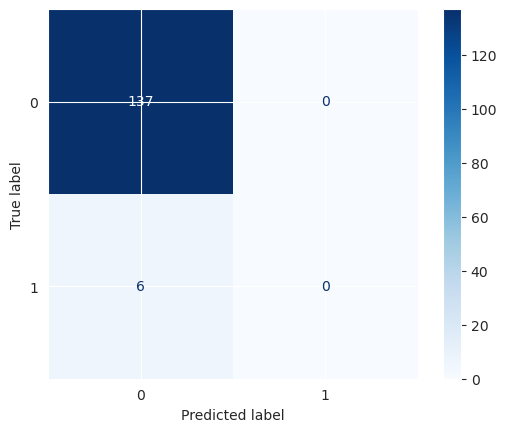



quality_of_life


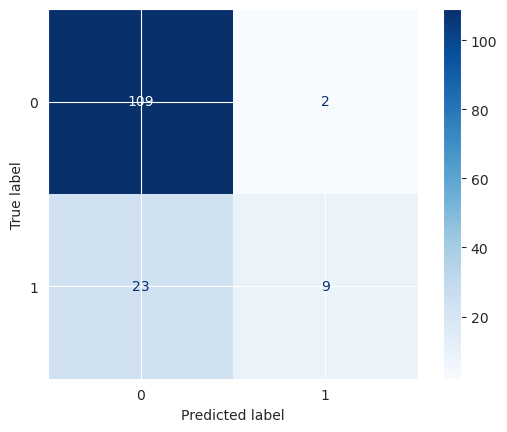



security_and_defense


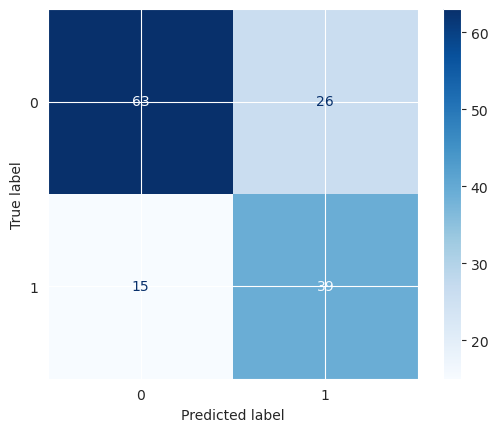






SVC
---
capacity_and_resources


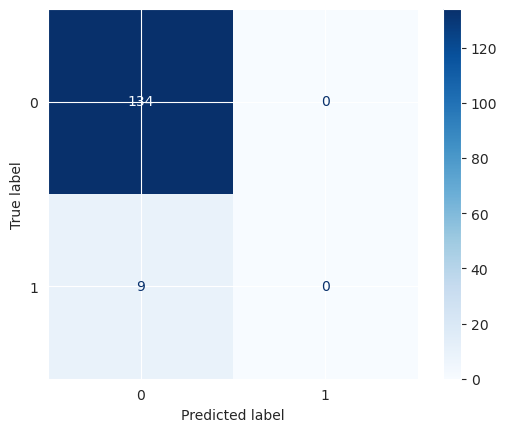



crime_and_punishment


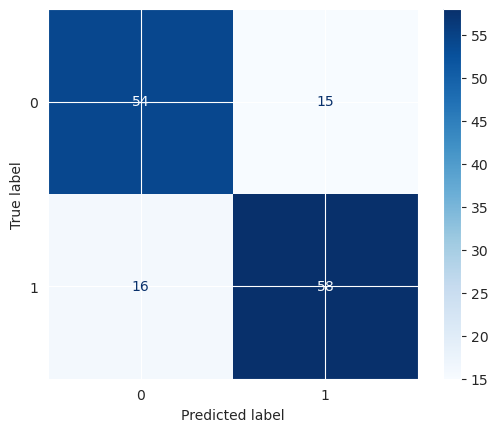



cultural_identity


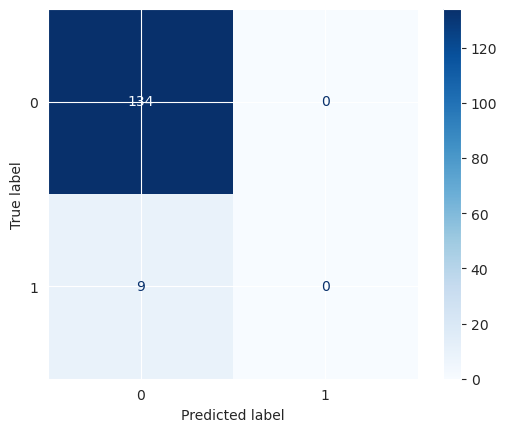



economic


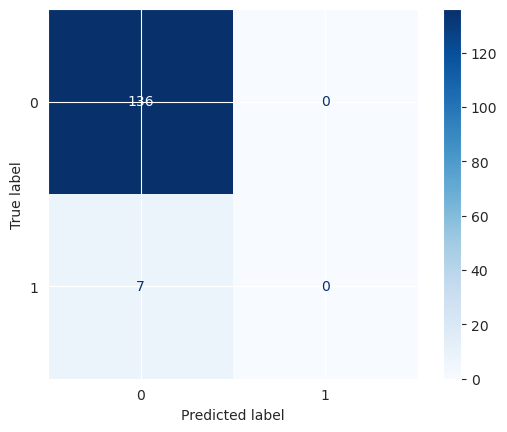



external_regulation_and_reputation


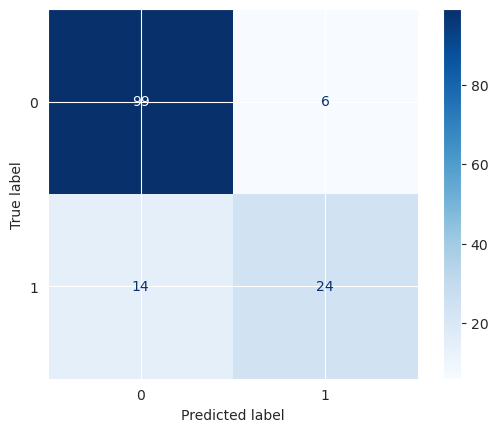



fairness_and_equality


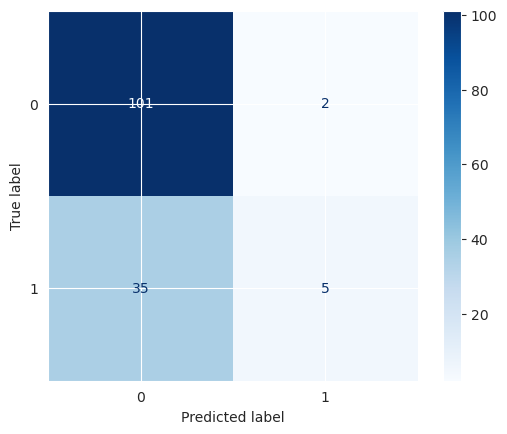



health_and_safety


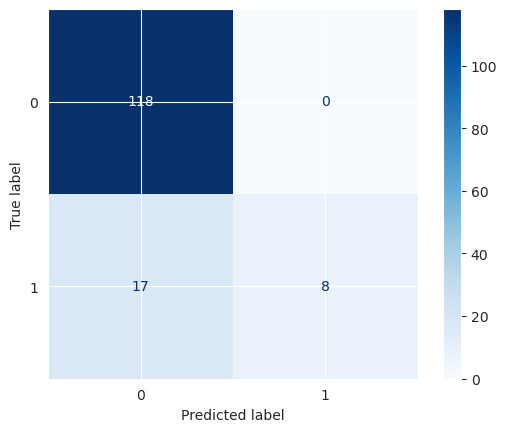



legality_constitutionality_and_jurisprudence


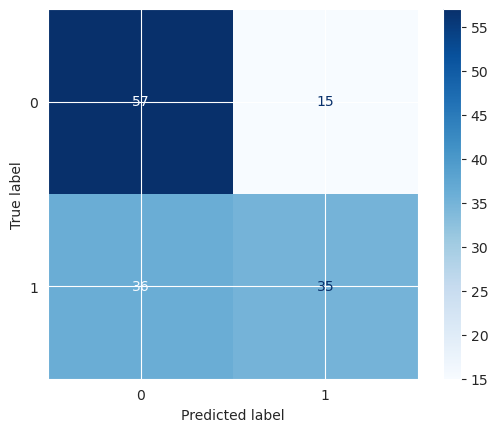



morality


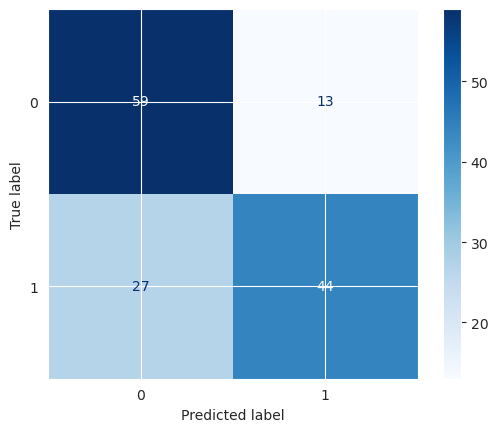



policy_prescription_and_evaluation


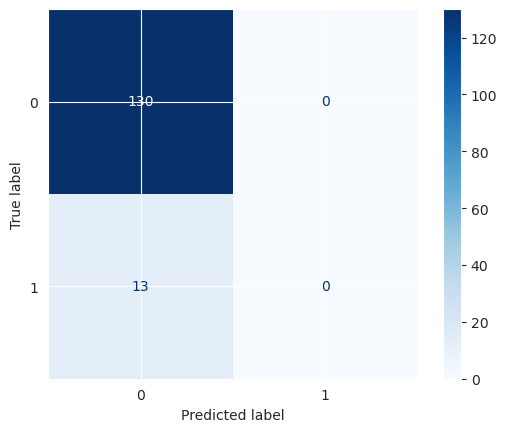



political


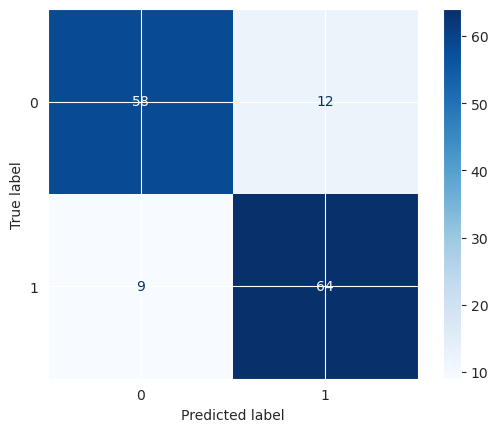



public_opinion


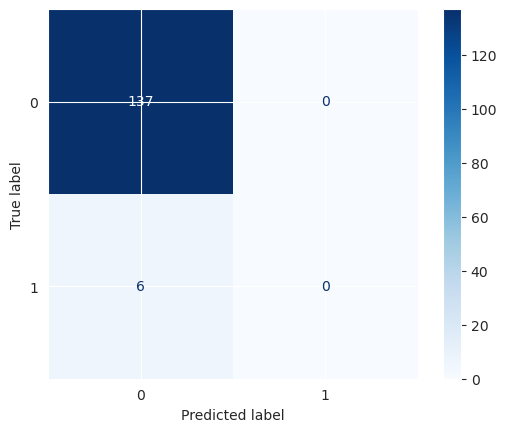



quality_of_life


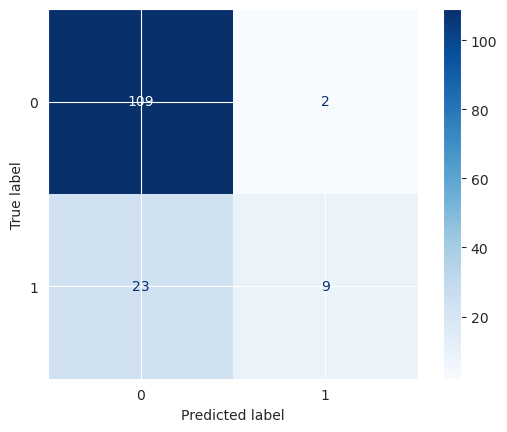



security_and_defense


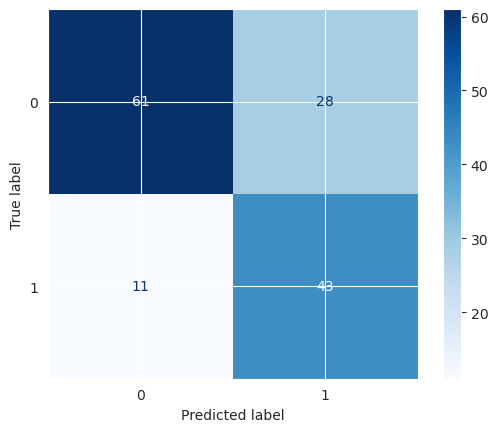






RandomForestClassifier
----------------------
capacity_and_resources


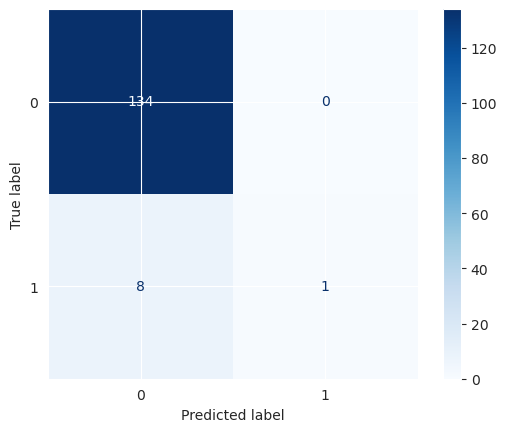



crime_and_punishment


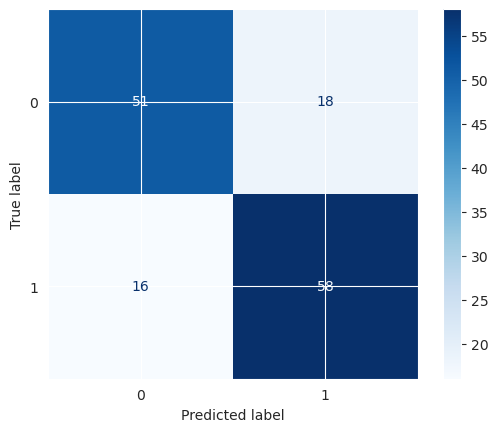



cultural_identity


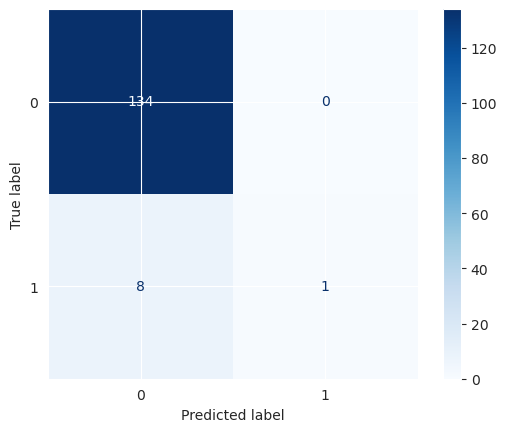



economic


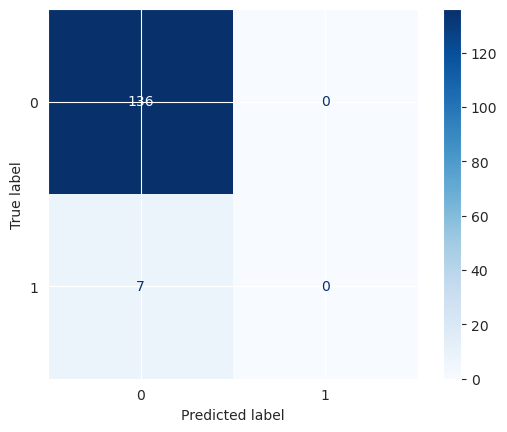



external_regulation_and_reputation


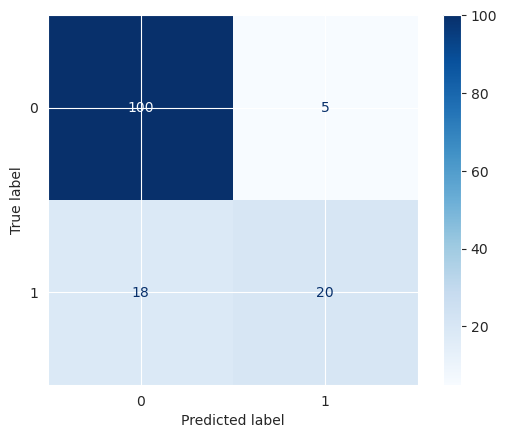



fairness_and_equality


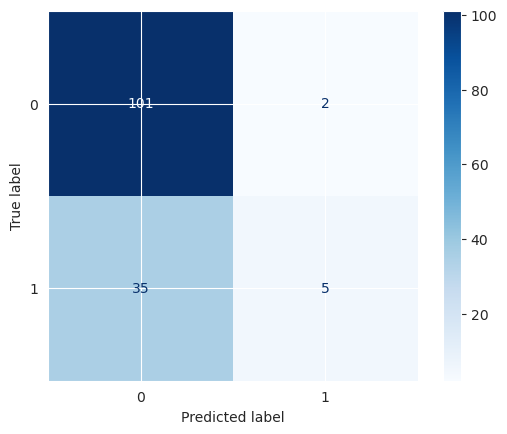



health_and_safety


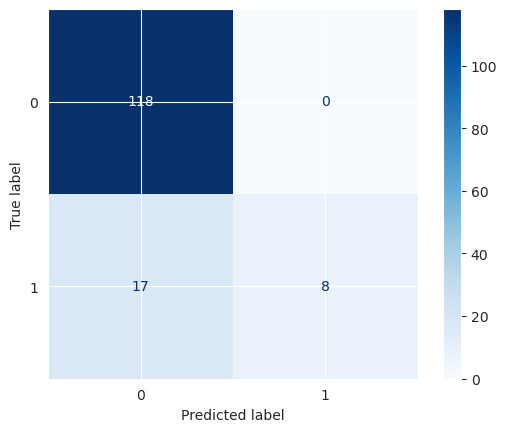



legality_constitutionality_and_jurisprudence


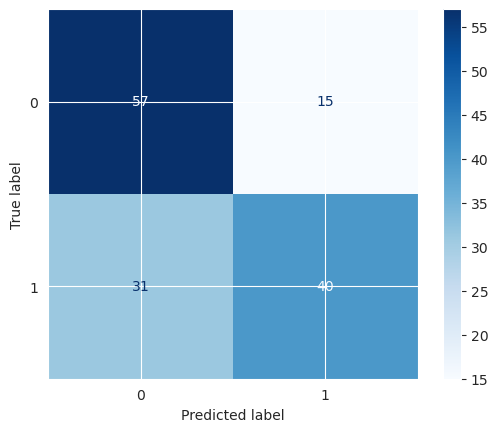



morality


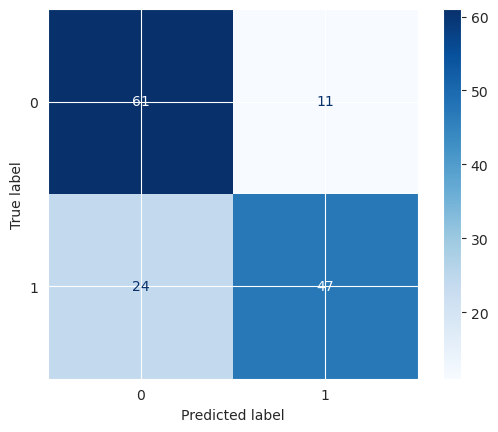



policy_prescription_and_evaluation


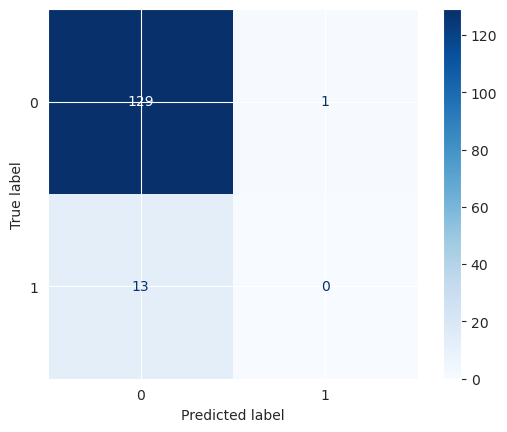



political


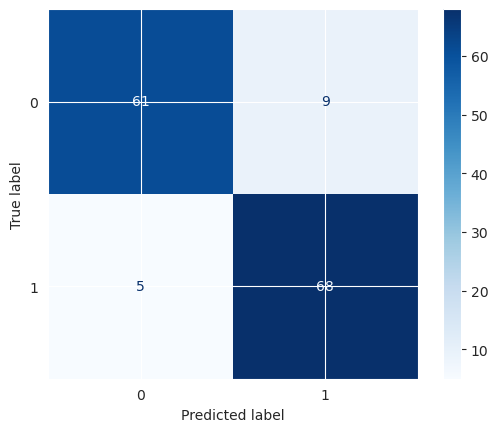



public_opinion


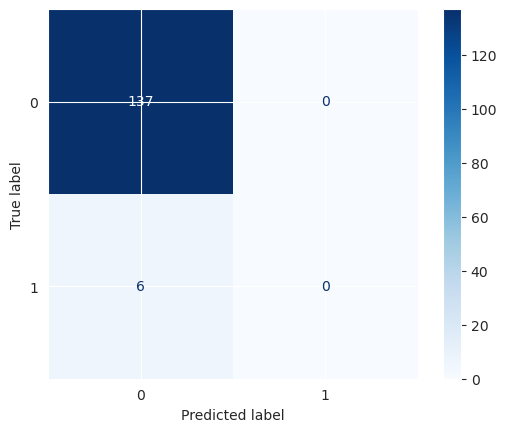



quality_of_life


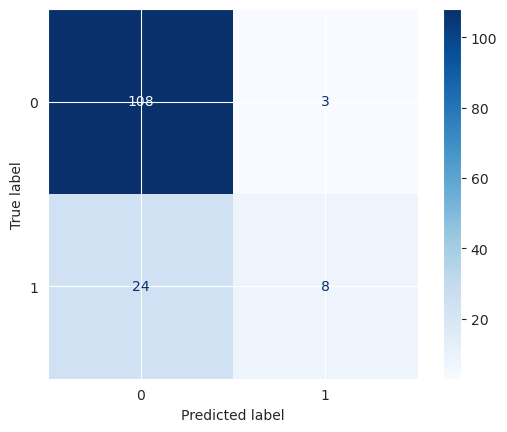



security_and_defense


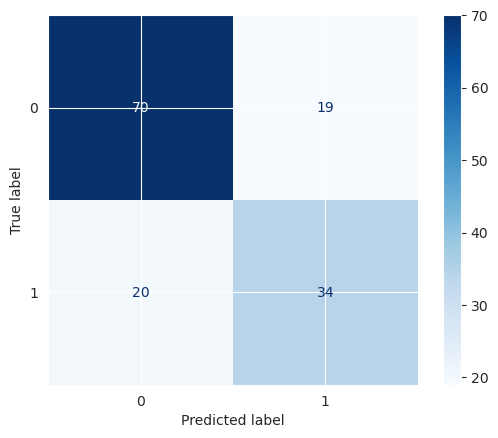






RidgeClassifier
---------------
capacity_and_resources


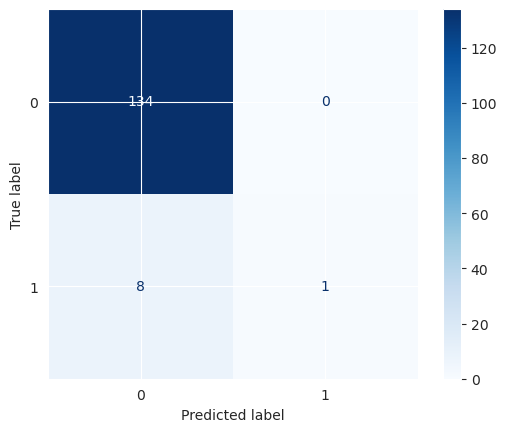



crime_and_punishment


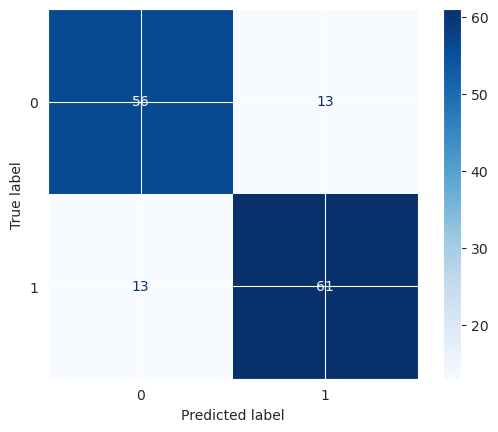



cultural_identity


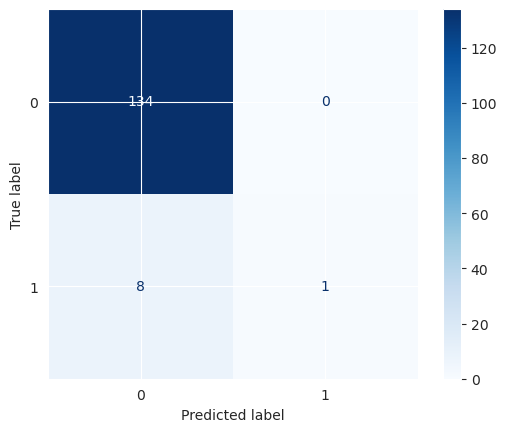



economic


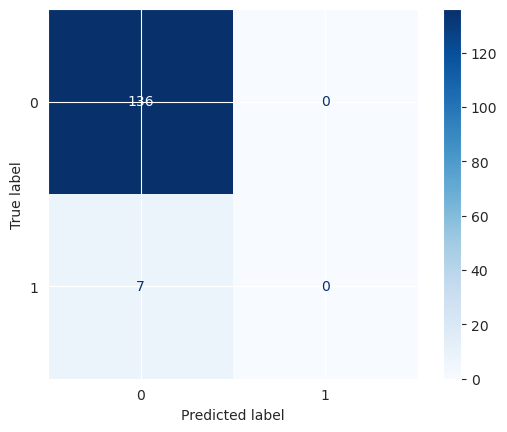



external_regulation_and_reputation


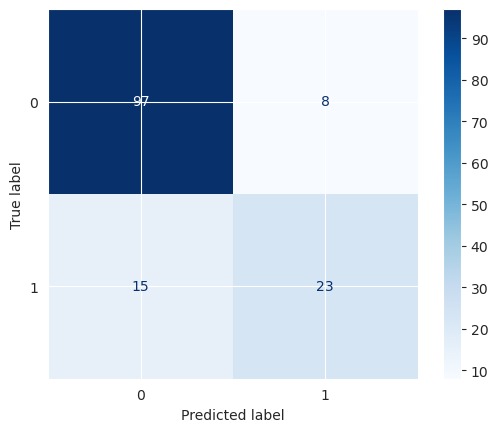



fairness_and_equality


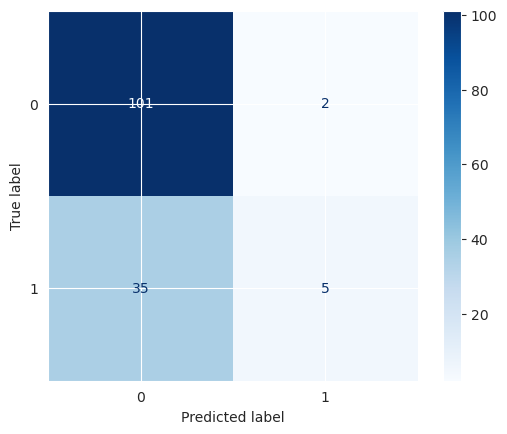



health_and_safety


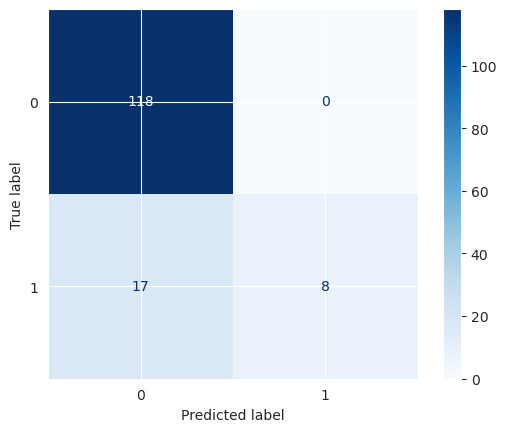



legality_constitutionality_and_jurisprudence


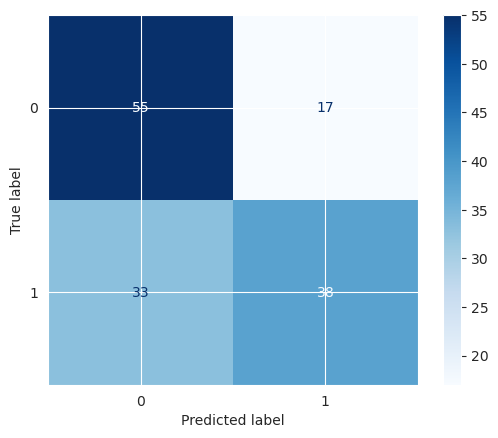



morality


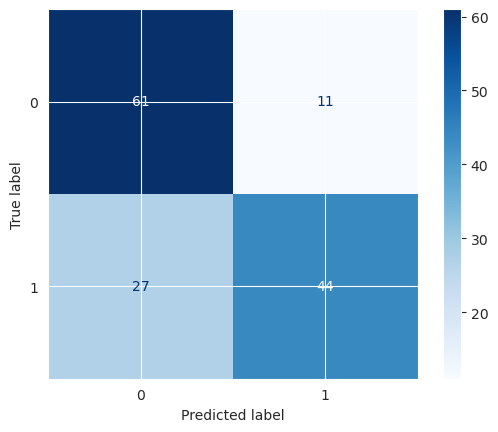



policy_prescription_and_evaluation


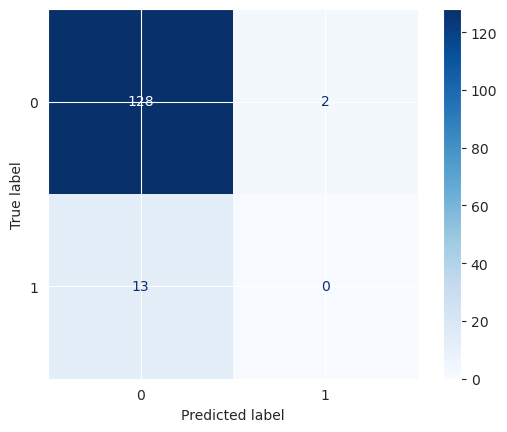



political


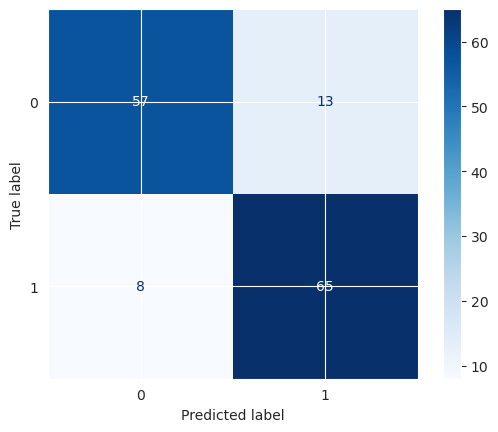



public_opinion


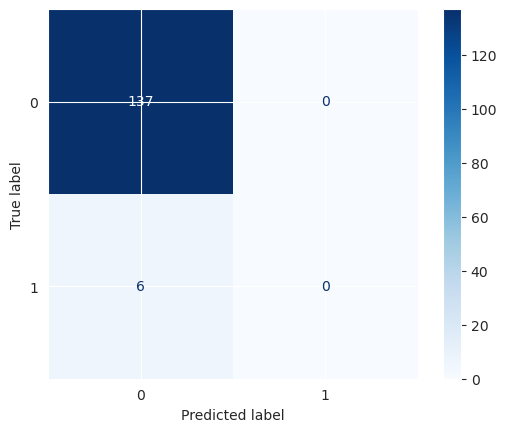



quality_of_life


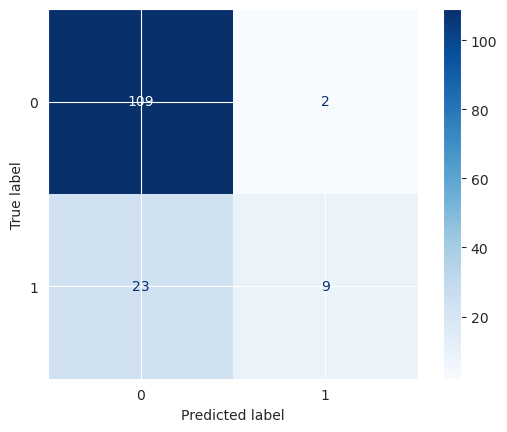



security_and_defense


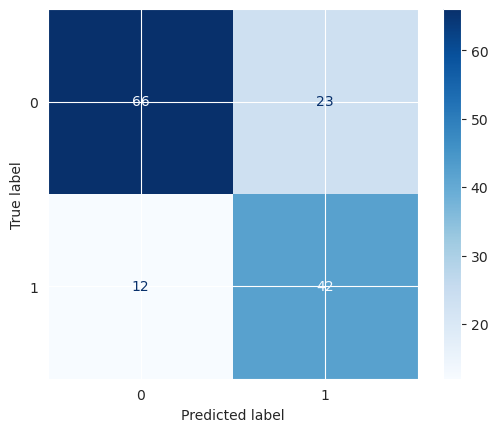

In [39]:

# Initiliaze, fit model and get confusion matrices
models = (LinearSVC(), SVC(), RandomForestClassifier(), RidgeClassifier())

for model in models:
    print(model.__class__.__name__)
    print(len(model.__class__.__name__)*'-')
    multilabel_cls = MultiLabelEstimator(
                base_estimator=model,
                base_estimator_hyperparam_dist=dict(),
                treat_labels_as_independent=True,
                scoring_functions=('f1_micro',)
            )

    # Fit model
    multilabel_cls.multi_label_estimator.fit(X_train, y_train)

    # Get predictions on test
    y_test_pred = multilabel_cls.multi_label_estimator.predict(X_test)

    # Print multilabel confusion matrix
    confusion_matrices = multilabel_confusion_matrix(y_true=y_test, y_pred=y_test_pred)
    for idx, label in enumerate(mlb.classes_):
        print(label)
        cm_plot = ConfusionMatrixDisplay(confusion_matrices[idx, :, :])
        cm_plot.plot(cmap='Blues')
        plt.show()
        print('\n')

    print('\n\n')